In [1]:
#%matplotlib widget
%config InlineBackend.figure_format = 'retina'
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy.interpolate import interp1d
from transformations import * 
plt.rc('figure', figsize=(10,5))
#plt.rc('figure', figsize=(20,15))

def quat2eulers(w, x, y ,z):
    r = atan2(2 * (w * x + y * z),
                    1 - 2 * (x * x + y * y))
    p = asin(2 * (w * y - z * x))
    y = atan2(2 * (w * z + x * y), 1 - 2 * (y * y + z * z))
    return y, p, r

def RMSE(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def read_pose_swarm_fused(bag, topic, _id):
    pos = []
    ypr = []
    ts = []
    print(f"Read poses from topic {topic}")
    for topic, msg, t in bag.read_messages(topics=[topic]):
        for i in range(len(msg.ids)):
            _i = msg.ids[i]
            if _i == _id:
                ts.append(msg.header.stamp.to_sec())
                pos.append([msg.local_drone_position[i].x, msg.local_drone_position[i].y, msg.local_drone_position[i].z])
                ypr.append([msg.local_drone_yaw[i], 0, 0])
    ret = {
        "t": np.array(ts),
        "pos": np.array(pos),
        "ypr": np.array(ypr),
    }
    return ret

def read_pose_swarm_frame(bag, topic, _id):
    pos = []
    ypr = []
    ts = []
    print(f"Read poses from topic {topic}")
    for topic, msg, t in bag.read_messages(topics=[topic]):
        for node in msg.node_frames:
            _i = node.id
            if _i == _id:
                ts.append(node.header.stamp.to_sec())
                pos.append([node.position.x, node.position.y, node.position.z])
                ypr.append([node.yaw, 0, 0])
    ret = {
        "t": np.array(ts),
        "pos": np.array(pos),
        "ypr": np.array(ypr),
    }
    return ret

def read_pose(bag, topic):
    pos = []
    ypr = []
    ts = []
    print(f"Read poses from topic {topic}")
    for topic, msg, t in bag.read_messages(topics=[topic]):
        p = msg.pose.position
        q = msg.pose.orientation
        pos.append([p.x, p.y, p.z])
        y, p, r = quat2eulers(q.w, q.x, q.y, q.z)
        ypr.append([y, p, r])
        ts.append(msg.header.stamp.to_sec())
    ret = {
        "t": np.array(ts),
        "pos": np.array(pos),
       "pos_func": interp1d(ts, pos,axis=0,bounds_error=False),
        "ypr": np.array(ypr),
        "ypr_func": interp1d(ts, ypr,axis=0,bounds_error=False)
    }
    dp = np.diff(ret["pos"], axis=0)
    length = np.sum(np.linalg.norm(dp,axis=1))
    print("Trajectory total length ", length, np.linalg.norm(dp,axis=1))
    return ret

def read_loops(bag, topic="/swarm_loop/loop_connection"):
    loops = []
    for topic, msg, t in bag.read_messages(topics=[topic]):
        loop = {
            "ts_a": msg.ts_a.to_sec(),
            "ts_b": msg.ts_b.to_sec(),
            "id_a":msg.id_a,
            "id_b":msg.id_b,
            "dpos":np.array([msg.dpos.x, msg.dpos.y, msg.dpos.z]),
            "dyaw":msg.dyaw
        }
        loops.append(loop)
    return loops
    
def bag_read(bagname, nodes = [1, 2], is_pc=False, main_id=1):
    bag = rosbag.Bag(bagname)
    poses = {}
    loops = read_loops(bag, "/swarm_loop/loop_connection")
    poses_fused = {}
    poses_vo = {}
    for i in nodes:
        poses[i] =  read_pose(bag, f"/SwarmNode{i}/pose")
        if is_pc:
            poses_fused[i] = read_pose_swarm_fused(bag, "/swarm_drones/swarm_drone_fused_pc", i)
        else:
            poses_fused[i] = read_pose_swarm_fused(bag, "/swarm_drones/swarm_drone_fused", i)
        poses_vo[i] = read_pose_swarm_frame(bag, "/swarm_drones/swarm_frame_predict", i)
    bag.close()
    
    fused_offset = poses[main_id]["pos"][0] - poses_fused[main_id]["pos"][0]
    yaw_offset = (poses[main_id]["ypr"][0] - poses_fused[main_id]["ypr"][0])[0]
    Re = rotation_matrix(-yaw_offset, [0, 0, 1])[0:3, 0:3]
    for i in nodes:
        poses_fused[i]["pos"] = np.transpose(np.dot(Re, np.transpose(poses_fused[i]["pos"]))) + fused_offset
        poses_fused[i]["pos_func"] = interp1d( poses_fused[i]["t"],  poses_fused[i]["pos"],axis=0)

    for i in nodes:
        vo_offset = poses[i]["pos"][0] - poses_vo[i]["pos"][0]
        yaw_offset = (poses[i]["ypr"][0] - poses_vo[i]["ypr"][0])[0]
        Re = rotation_matrix(-yaw_offset, [0, 0, 1])[0:3, 0:3]
        poses_vo[i]["pos"] = np.transpose(np.dot(Re, np.transpose(poses_vo[i]["pos"]))) + vo_offset
        poses_vo[i]["pos_func"] = interp1d( poses_vo[i]["t"],  poses_vo[i]["pos"],axis=0,bounds_error=False)
                                                                                   
    return poses, loops, poses_fused, poses_vo
    
def plot_fused(poses, poses_fused, poses_vo):
    fig = plt.figure("Ground Truth3d")
    plt.title("Ground Truth3d")
    ax = fig.add_subplot(111, projection='3d')
    ax = fig.gca(projection='3d')
    
    for i in nodes:
        ax.plot(poses[i]["pos"][:,0], poses[i]["pos"][:,1],poses[i]["pos"][:,2], label=f"Vicon Traj{i}")
    
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_ylabel('$Z$')
    
    #Plot Loops
    quivers = []
    for loop in loops:
        posa_gt = poses[loop["id_a"]]["pos_func"](loop["ts_a"])
        posb_gt = poses[loop["id_b"]]["pos_func"](loop["ts_b"])
        quivers.append([posa_gt[0], posa_gt[1], posa_gt[2], posb_gt[0]-posa_gt[0], posb_gt[1]-posa_gt[1], posb_gt[2]-posa_gt[2]])
        
    quivers = np.array(quivers)
    c = np.arctan2(quivers[:,4], quivers[:,3])
    c = (c.ravel() - c.min()) / c.ptp()
    c = np.concatenate((c, np.repeat(c, 2)))
    c = plt.cm.hsv(c)
    ax.quiver(quivers[:,0], quivers[:,1], quivers[:,2], quivers[:,3], quivers[:,4], quivers[:,5], arrow_length_ratio=0.1, colors = c)

    plt.legend()
    plt.show()


    #Plot Fused Vs GT 3D
    fig = plt.figure("Fused Vs GT 3D")
    plt.title("Fused Vs GT 3D")
    for i in nodes:
        ax = fig.add_subplot(120 + i, projection='3d')
        ax = fig.gca(projection='3d')
        ax.plot(poses[i]["pos"][:,0], poses[i]["pos"][:,1],poses[i]["pos"][:,2], label=f"Vicon Traj{i}")
        ax.plot(poses_fused[i]["pos"][:,0], poses_fused[i]["pos"][:,1],poses_fused[i]["pos"][:,2], label=f"Fused Traj{i}")
        #ax.plot(poses_vo[i]["pos"][:,0], poses_vo[i]["pos"][:,1],poses_vo[i]["pos"][:,2], label=f"Vicon VO{i}")
        
        plt.legend()
        ax.set_xlabel('$X$')
        ax.set_ylabel('$Y$')
        ax.set_ylabel('$Z$')
    
    plt.show()


    fig = plt.figure("Fused Vs GT 2D")
    plt.title("Fused Vs GT 2D")
    for i in nodes:
        ax = fig.add_subplot(120 + i)
        ax.plot(poses[i]["pos"][:,0], poses[i]["pos"][:,1], label=f"Vicon Traj{i}")
        ax.plot(poses_fused[i]["pos"][:,0], poses_fused[i]["pos"][:,1], label=f"Fused Traj{i}")
        #ax.plot(poses_vo[i]["pos"][:,0], poses_vo[i]["pos"][:,1], label=f"Aligned VO Traj{i}")
        plt.grid()
        plt.legend()
    plt.show()
    
def plot_fused_err(poses, poses_fused, poses_vo, main_id=1):
    t_calib = -0.2
    fig = plt.figure("Fused Vs GT 1D")
    plt.title("Fused Vs GT 1D")
    ax1, ax2, ax3 = fig.subplots(3, 1)

    for i in nodes:
        t_ = poses_fused[i]["t"]
        pos_gt =  poses[i]["pos_func"](poses_fused[i]["t"])
        pos_fused = poses_fused[i]["pos"]
        _i = str(i) 

        ax1.plot(t_, pos_gt[:,0], label="$x_{gt}^" + _i + "$")
        ax1.plot(t_, pos_fused[:,0], label="$x_{fused}^" + _i + "$")

        ax2.plot(t_, pos_gt[:,1], label="$y_{gt}^" + _i + "$")
        ax2.plot(t_, pos_fused[:,1], label="$y_{fused}^" + _i + "$")

        ax3.plot(t_, pos_gt[:,2], label="$z_{gt}^" + _i + "$")
        ax3.plot(t_, pos_fused[:,2], label="$z_{fused}^" + _i + "$")

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.show()

    #Plot Fused Vs GT absolute error
    fig = plt.figure("Fused Absolute Error")
    plt.title("Fused Absolute Error")
    ax1, ax2, ax3 = fig.subplots(3, 1)
    for i in nodes:
        t_ = poses_fused[i]["t"]
        t0 =t_[0]
        pos_gt =  poses[i]["pos_func"](poses_fused[i]["t"]+t_calib)
        pos_fused = poses_fused[i]["pos"]
        pos_vo = poses_vo[i]["pos"]
        _i = str(i) 
        rmse_x = RMSE(pos_gt[:,0] , pos_fused[:,0])
        rmse_y = RMSE(pos_gt[:,1] , pos_fused[:,1])
        rmse_z = RMSE(pos_gt[:,2] , pos_fused[:,2])
        
        label = f"$errx_{i}$ RMSE{i}:{rmse_x:3.3f}"
        ax1.plot(t_, pos_gt[:,0]  - pos_fused[:,0], label=label)

        label = f"$erry_{i}$ RMSE{i}:{rmse_y:3.3f}"
        ax2.plot(t_, pos_gt[:,1]  - pos_fused[:,1], label=label)

        label = f"$erry_{i}$ RMSE{i}:{rmse_z:3.3f}"
        ax3.plot(t_,  pos_gt[:,1]  - pos_fused[:,1], label=label)

        pos_gt =  poses[i]["pos_func"](poses_vo[i]["t"]+t_calib)
        
        rmse_vo_x = RMSE(pos_vo[:,0] , pos_gt[:,0])
        rmse_vo_y = RMSE(pos_vo[:,1] , pos_gt[:,1])
        rmse_vo_z = RMSE(pos_vo[:,2] , pos_gt[:,2])
        
#         label = f"$VO errx_{i}$ RMSE{i}:{rmse_vo_x:3.3f}"
#         ax1.plot(poses_vo[i]["t"], pos_gt[:,0]  - pos_vo[:,0], label=label)

#         label = f"$VO erry_{i}$ RMSE{i}:{rmse_vo_y:3.3f}"
#         ax2.plot(poses_vo[i]["t"], pos_gt[:,1]  - pos_vo[:,1], label=label)
        
#         label = f"$VO errz_{i}$ RMSE{i}:{rmse_vo_z:3.3f}"
#         ax3.plot(poses_vo[i]["t"], pos_gt[:,2]  - pos_vo[:,2], label=label)
    
        print(f"RMSE {i} is {rmse_x:3.3f},{rmse_y:3.3f},{rmse_z:3.3f}")
        print(f"RMSE VO {i} is {rmse_vo_x:3.3f},{rmse_vo_y:3.3f},{rmse_vo_z:3.3f}")

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.show()

    fig = plt.figure("Relative Pose")
    plt.title("Relative Pose")
    
    ts = poses_fused[main_id]["t"]
    posa_gt =  poses[main_id]["pos_func"](ts)
    posa_fused =  poses[main_id]["pos_func"](ts)
    posa_vo =  poses[main_id]["pos_func"](ts)
    ax1, ax2, ax3 = fig.subplots(3, 1)
    
    for i in nodes:
        if i!= main_id:
            posb_gt =  poses[i]["pos_func"](poses_fused[i]["t"])
            posb_fused = poses_fused[i]["pos"]
            posb_vo = poses_fused[i]["pos"]
            
            dp_gt = posb_gt - posa_gt
            dp_fused = posb_fused - posa_fused
            dp_vo = posb_vo - posa_vo
            
            ax1.plot(ts, dp_gt[:,0], label="$X_{gt}^" + str(i) + "$")
            ax2.plot(ts, dp_gt[:,1], label="$Y_{gt}^" + str(i) + "$")
            ax3.plot(ts, dp_gt[:,2], label="$Z_{gt}^" + str(i) + "$")

            ax1.plot(ts, dp_fused[:,0], label="$X_{fused}^" + str(i) + "$")
            ax2.plot(ts, dp_fused[:,1], label="$Y_{fused}^" + str(i) + "$")
            ax3.plot(ts, dp_fused[:,2], label="$Z_{fused}^" + str(i) + "$")
            
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.show()
        
    fig = plt.figure("Fused Relative Error")
    plt.title("Fused Relative Error")
    ax1, ax2, ax3 = fig.subplots(3, 1)
    for i in nodes:
        if i!= main_id:
            posb_gt =  poses[i]["pos_func"](poses_fused[i]["t"])
            posb_fused = poses_fused[i]["pos"]
            posb_vo = poses_fused[i]["pos"]

            dp_gt = posb_gt - posa_gt
            dp_fused = posb_fused - posa_fused
            dp_vo = posb_vo - posa_vo

            rmse_x = RMSE(dp_gt[:,0] , dp_fused[:,0])
            rmse_y = RMSE(dp_gt[:,1] , dp_fused[:,1])
            rmse_z = RMSE(dp_gt[:,2] , dp_fused[:,2])

            ax1.plot(ts, dp_gt[:,0] - dp_fused[:,0], label="$E_{xfused}^" + str(i) + f"$ RMSE:{rmse_x:3.3f}")
            ax2.plot(ts, dp_gt[:,1] - dp_fused[:,1], label="$E_{yfused}^" + str(i) + f"$ RMSE:{rmse_y:3.3f}")
            ax3.plot(ts, dp_gt[:,2] - dp_fused[:,2], label="$E_{zfused}^" + str(i) + f"$ RMSE:{rmse_z:3.3f}")
            print(f"RMSE {main_id}->{i} {rmse_x:3.3f},{rmse_y:3.3f},{rmse_z:3.3f}")
            
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.show()
    
    fig = plt.figure("Yaw")
    plt.title("yaw")
    ax1, ax2 = fig.subplots(2, 1)
    for i in nodes:
        t_ = poses_fused[i]["t"]
        yaw_gt =  poses[i]["ypr_func"](poses_fused[i]["t"])
        yaw_fused = poses_fused[i]["ypr"]
        
        ax1.plot(t_,  yaw_gt[:,0], label=f"$\psi_g{i}$")
        ax1.plot(t_,  yaw_fused[:,0], label=f"$\psi_f{i}$")
        
        ax2.plot(t_,  (yaw_fused[:,0] -  yaw_gt[:,0] + np.pi) % (2 * np.pi) - np.pi, label=f"$\psi_E{i}$")
        
        yaw_gt=  poses[i]["ypr_func"](poses_vo[i]["t"])
        ax2.plot(poses_vo[i]["t"],  (poses_vo[i]["ypr"][:,0] -  yaw_gt[:,0] + np.pi) % (2 * np.pi) - np.pi, label=f"$VO \psi_E{i}$")
        
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend() 
    plt.show()


Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Read poses from topic /SwarmNode1/pose
Trajectory total length  62.7259658519951 [8.24984866e-06 1.16375705e-05 1.07865451e-05 ... 1.91359761e-05
 7.22168767e-04 1.09788116e-05]
Read poses from topic /swarm_drones/swarm_drone_fused_pc
Read poses from topic /swarm_drones/swarm_frame_predict
Read poses from topic /SwarmNode2/pose
Trajectory total length  51.45799648270558 [8.29577903e-06 2.94122854e-05 1.62564298e-05 ... 7.00922255e-06
 1.31699629e-05 1.91815179e-05]
Read poses from topic /swarm_drones/swarm_drone_fused_pc
Read poses from topic /swarm_drones/swarm_frame_predict


<ipython-input-1-c3365cd7f524>:132: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='3d')


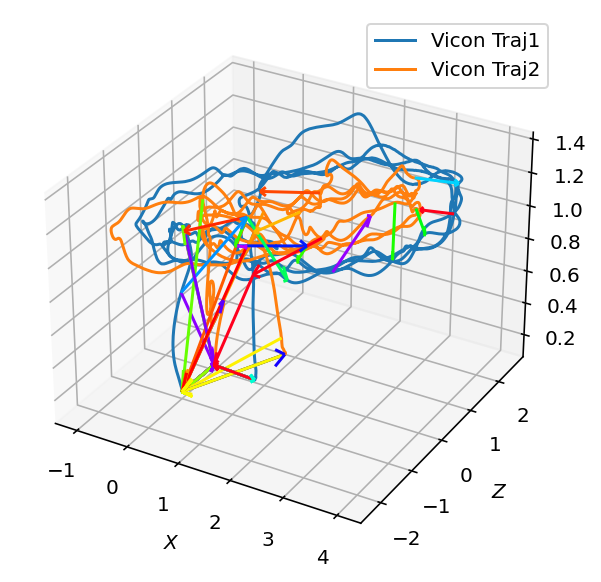

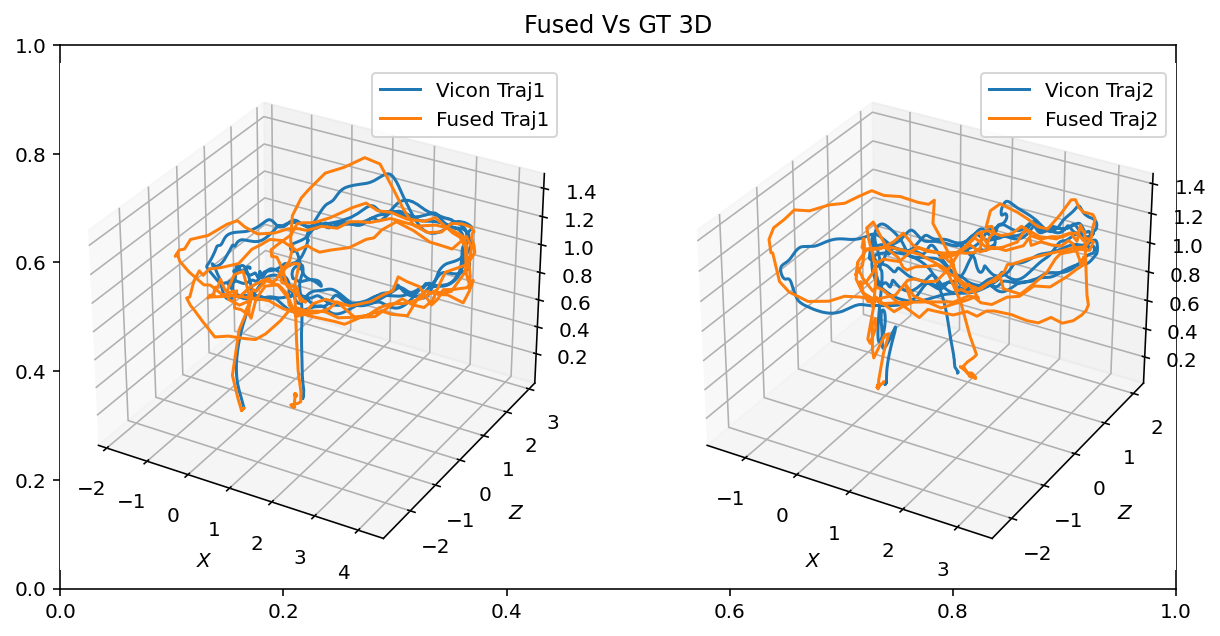

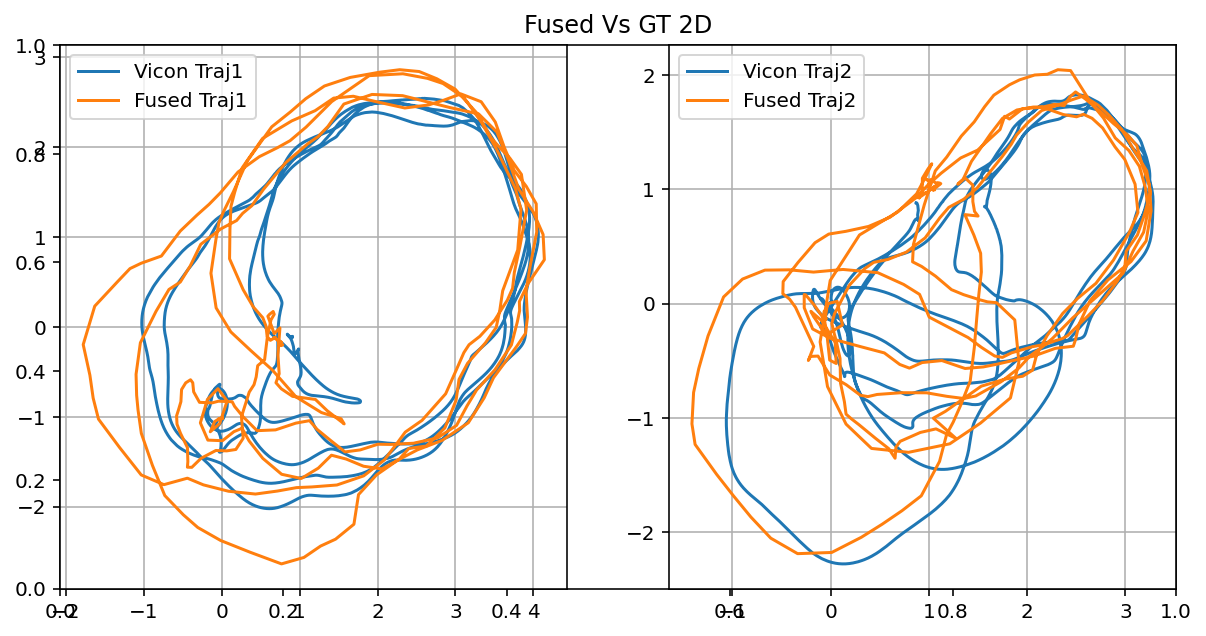

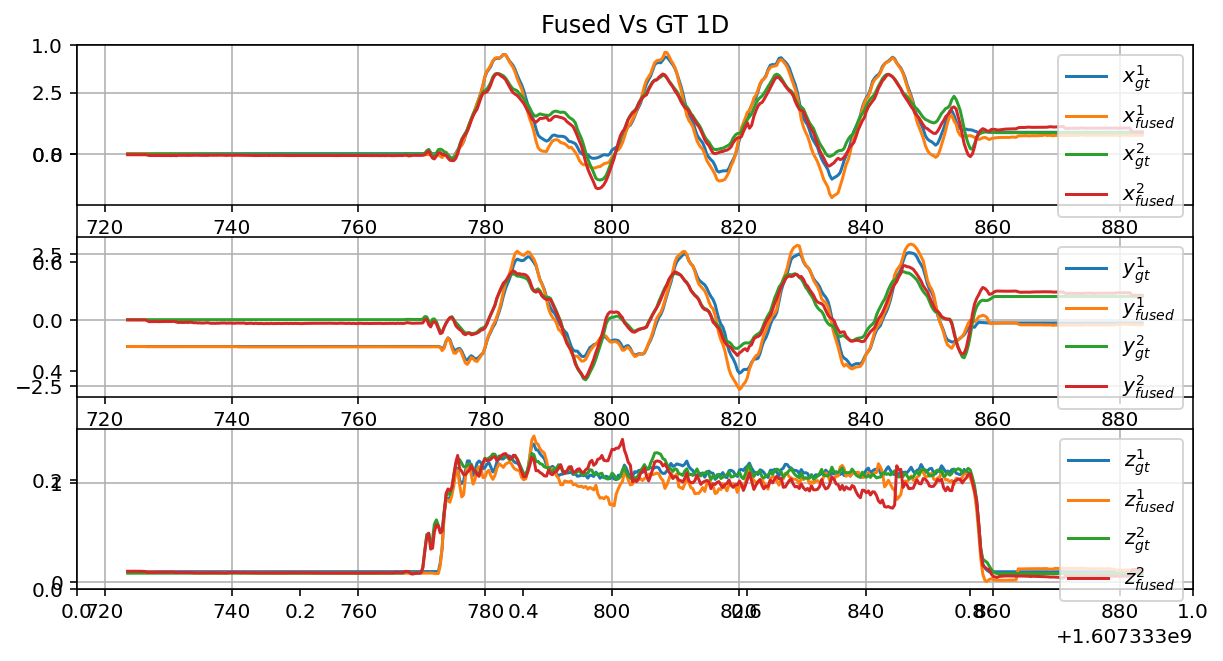

RMSE 1 is 0.247,0.214,0.082
RMSE VO 1 is 0.308,0.352,0.093
RMSE 2 is 0.199,0.156,0.089
RMSE VO 2 is 0.151,0.226,0.082


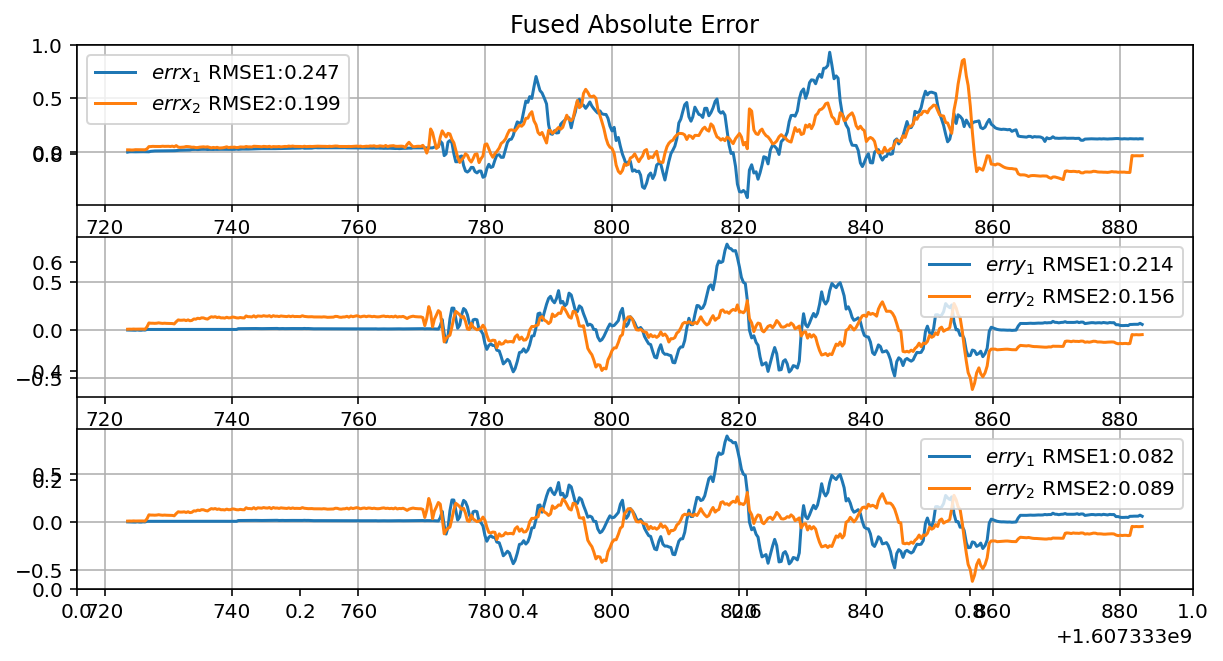

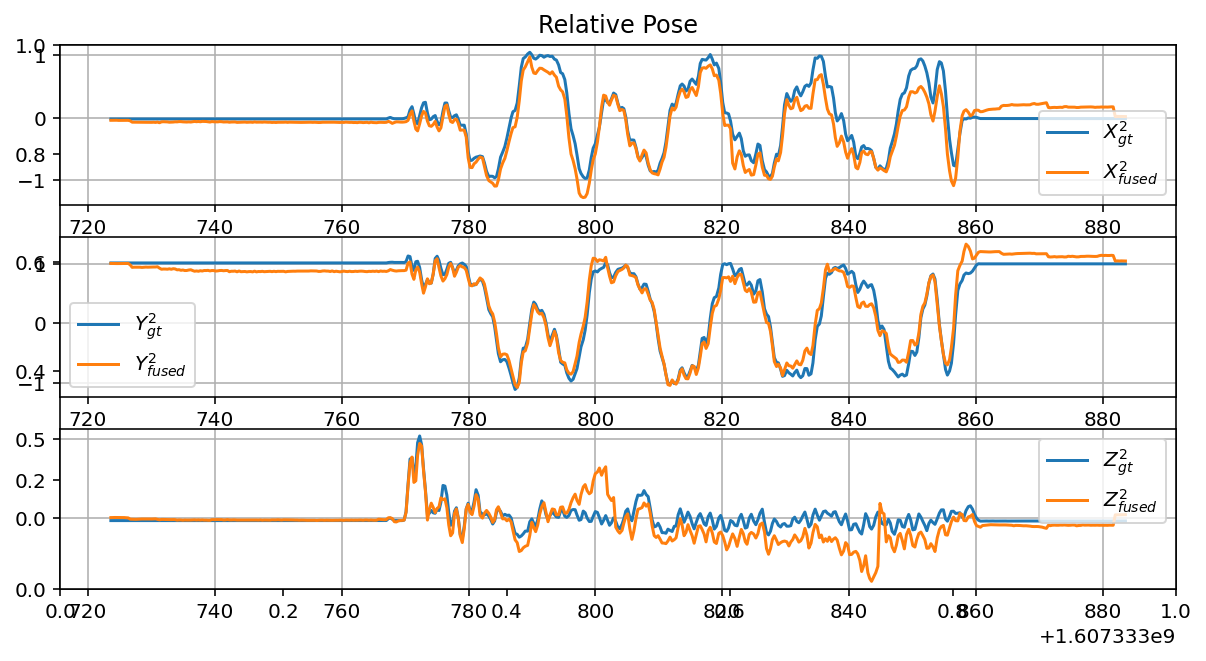

RMSE 1->2 0.183,0.146,0.087


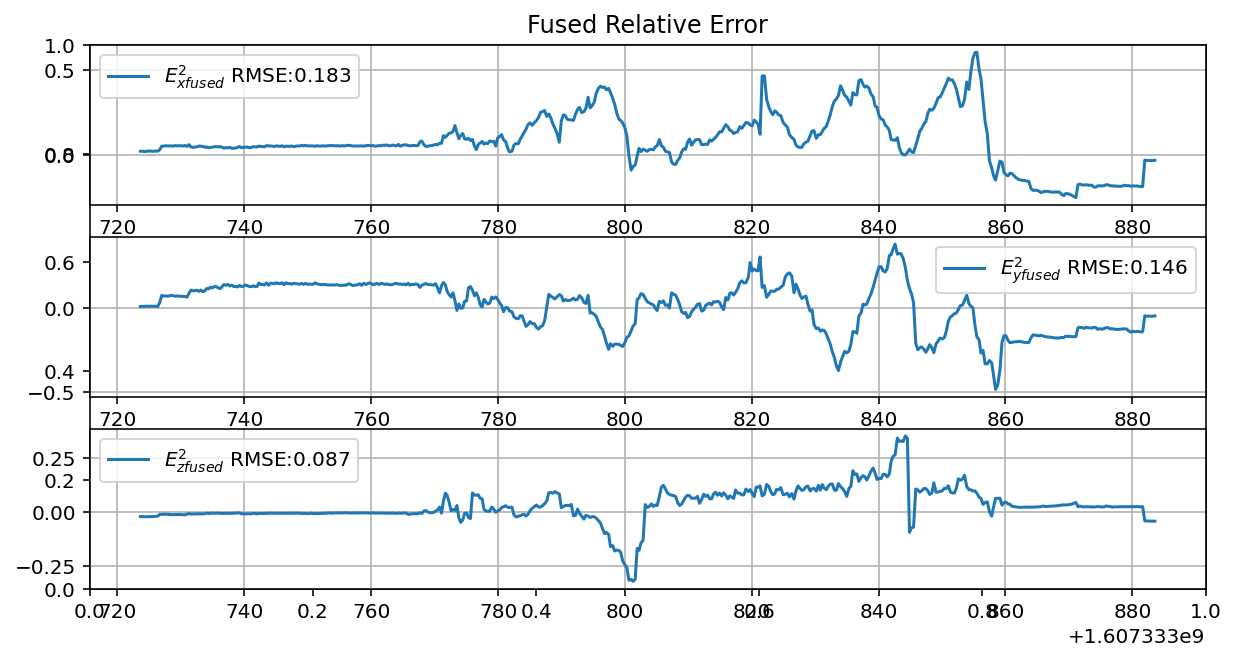

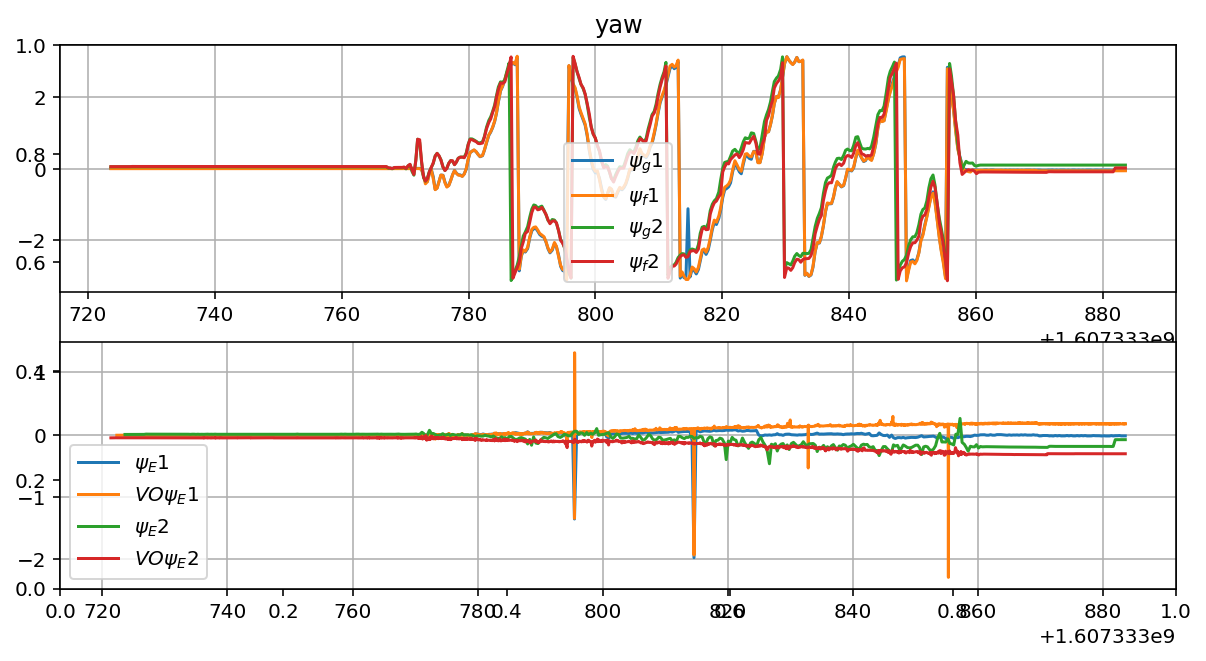

In [2]:
nodes = [1, 2]
#poses, loops , poses_fused =bag_read("data/swarm_local_2020-12-05-23-31-24-flyzone.bag", nodes) ##This bag has out of flyzone part
#poses, loops , poses_fused =bag_read("data/swarm_local_2020-12-05-23-31-24.bag", nodes) ##This bag has out of flyzone part
#poses, loops, poses_fused, poses_vo= bag_read("data/swarm_local_2020-12-07-17-09-41.bag", nodes, False)
#poses, loops, poses_fused, poses_vo  = bag_read("data/swarm_local_2020-12-07-17-34-57.bag", nodes, False)
poses, loops, poses_fused, poses_vo = bag_read("data/swarm_local_pc.bag", nodes, True)
plot_fused(poses, poses_fused, poses_vo)
plot_fused_err(poses, poses_fused, poses_vo)


Total loops 78
Error 4.176388161081254 {'ts_a': 1607333783.4896495, 'ts_b': 1607333784.014473, 'id_a': 2, 'id_b': 1, 'dpos': array([ 0.87191366,  3.40617199, -0.27344697]), 'dyaw': 0.1772447137852966}
Error 1.2904963567958225 {'ts_a': 1607333820.9396555, 'ts_b': 1607333721.968874, 'id_a': 2, 'id_b': 1, 'dpos': array([ 0.01956518, -0.24168934, -0.87646124]), 'dyaw': 0.094772837973626}
Error 1.955376236525415 {'ts_a': 1607333858.6896696, 'ts_b': 1607333721.968874, 'id_a': 2, 'id_b': 1, 'dpos': array([0., 0., 0.]), 'dyaw': 0.0}
Error 2.0760786407161564 {'ts_a': 1607333880.8896627, 'ts_b': 1607333721.968874, 'id_a': 2, 'id_b': 1, 'dpos': array([0., 0., 0.]), 'dyaw': 0.0}


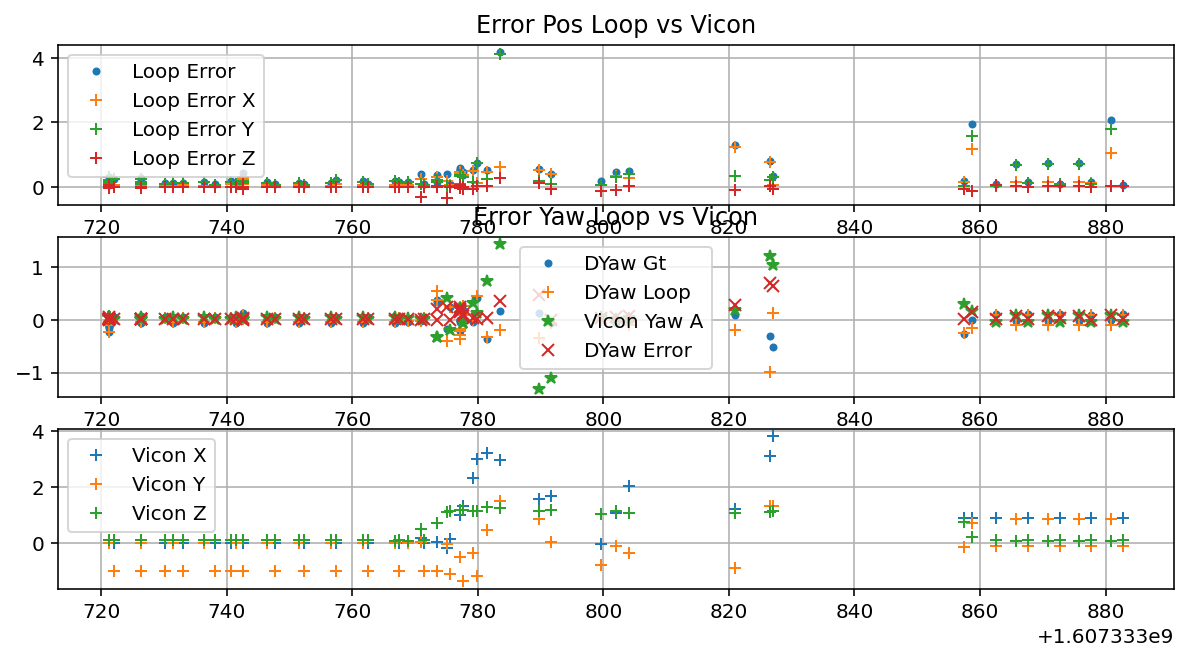

Pos cov 0.08672705896599142 0.33853914305915234 0.006549974672347518
Yaw cov 0.020961324630109177


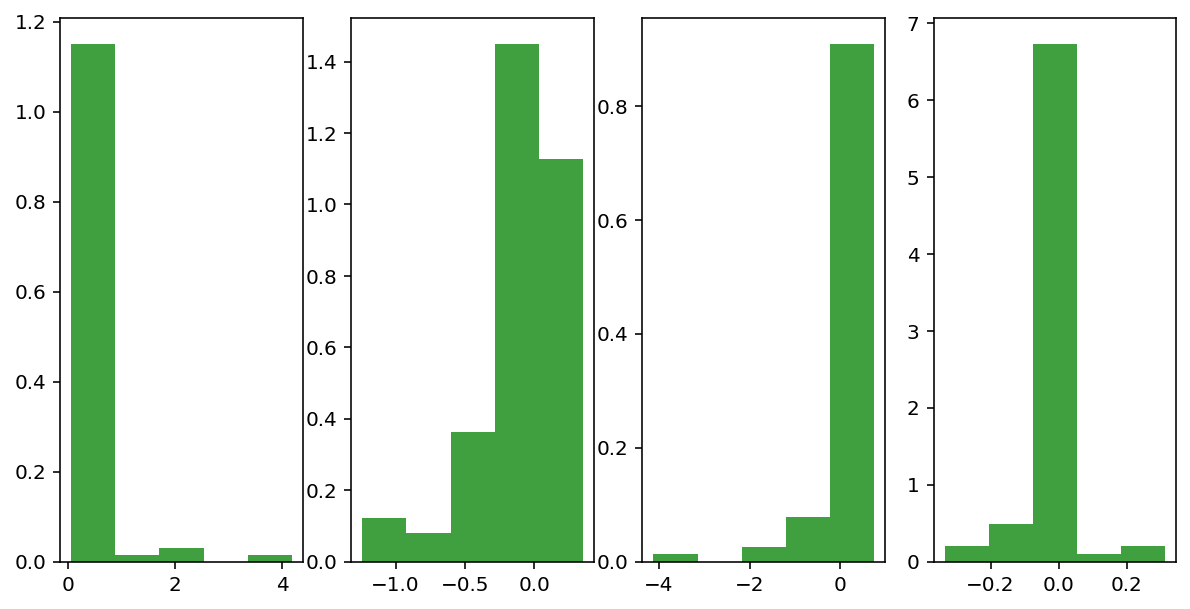

In [3]:
_loops_data = []
dpos_loops = []
dpos_gts = []
dpos_gt_norms= []
dpos_loop_norms= []
dpos_errs = []
dpos_errs_norm = []
posa_gts = []
ts_a = []
dyaws = []
dyaw_gts = []
yawa_gts = []
yawb_gts = []
dyaw_errs = []
print("Total loops", len(loops))
for loop in loops:
    posa_gt = poses[loop["id_a"]]["pos_func"](loop["ts_a"])
    posb_gt = poses[loop["id_b"]]["pos_func"](loop["ts_b"])
    yawa_gt = poses[loop["id_a"]]["ypr_func"](loop["ts_a"])[0]
    yawb_gt = poses[loop["id_b"]]["ypr_func"](loop["ts_b"])[0]
    dyaw_gt = yawb_gt - yawa_gt
    dpos_gt = np.array(posb_gt - posa_gt)
    dpos_gt = np.transpose([dpos_gt])
    Re = rotation_matrix(-yawa_gt, [0, 0, 1])[0:3, 0:3]
    dpos_gt = np.dot(Re, dpos_gt)
    dpos_gt = dpos_gt.flatten()
    dpos_loop = np.array(loop["dpos"])
    _loops_data.append({
        "dpos_loop": dpos_loop,
        "dpos_gt": dpos_gt,
        "dpos_err": dpos_gt - dpos_loop
        })
    dpos_loops.append(dpos_loop)
    dpos_gts.append(dpos_gt)
    dpos_errs.append(dpos_gt - dpos_loop)    
    dpos_gt_norms.append(np.linalg.norm(dpos_gt))
    dpos_loop_norms.append(np.linalg.norm(dpos_loop))
    dpos_errs_norm.append(np.linalg.norm(dpos_gt - dpos_loop))
    posa_gts.append(posa_gt)
    dyaws.append(loop["dyaw"])
    dyaw_gts.append(yawb_gt-yawa_gt)
    ts_a.append(loop["ts_a"])
    yawa_gts.append(yawa_gt)
    yawb_gts.append(yawb_gt)
    dyaw_errs.append(yawb_gt-yawa_gt-loop["dyaw"])
    
    if np.linalg.norm(dpos_gt - dpos_loop) > 1.0:
        print("Error", np.linalg.norm(dpos_gt - dpos_loop) , loop)
    
posa_gts = np.array(posa_gts)
dpos_errs = np.array(dpos_errs)
fig = plt.figure()

plt.subplot(311)
plt.plot(ts_a, dpos_errs_norm, '.', label="Loop Error")
plt.plot(ts_a, np.abs(dpos_errs[:,0]), '+', label="Loop Error X")
plt.plot(ts_a, np.abs(dpos_errs[:,1]), '+', label="Loop Error Y")
plt.plot(ts_a, dpos_errs[:,2], '+', label="Loop Error Z")
plt.title("Error Pos Loop vs Vicon")
plt.grid(which="both")
plt.legend()

plt.subplot(312)
plt.plot(ts_a, dyaws, '.', label="DYaw Gt")
plt.plot(ts_a, dyaw_gts, '+', label="DYaw Loop")
plt.plot(ts_a, yawa_gts, "*", label="Vicon Yaw A")
plt.plot(ts_a, np.abs(dyaw_errs), "x", label="DYaw Error")

#plt.plot(ts_a, yawb_gts, "*", label="Vicon Yaw B")
plt.title("Error Yaw Loop vs Vicon")
plt.grid(which="both")
plt.legend()


plt.subplot(313)
plt.plot(ts_a, posa_gts[:,0], '+', label="Vicon X")
plt.plot(ts_a, posa_gts[:,1], '+', label="Vicon Y")
plt.plot(ts_a, posa_gts[:,2], '+', label="Vicon Z")
# plt.plot(poses[i]["t"], poses[i]["pos"][:,0], label="Vicon X")
# plt.plot(poses[i]["t"], poses[i]["pos"][:,1], label="Vicon Y")
# plt.plot(poses[i]["t"], poses[i]["pos"][:,2], label="Vicon Z")

plt.grid(which="both")
plt.legend()
plt.show()

plt.figure()
plt.subplot(141)
plt.hist(dpos_errs_norm, 5, density=True, facecolor='g', alpha=0.75)
plt.subplot(142)
plt.hist(dpos_errs[:,0], 5, density=True, facecolor='g', alpha=0.75)
plt.subplot(143)
plt.hist(dpos_errs[:,1], 5, density=True, facecolor='g', alpha=0.75)
plt.subplot(144)
plt.hist(dpos_errs[:,2], 5, density=True, facecolor='g', alpha=0.75)


print("Pos cov", np.cov(dpos_errs[:,0]), np.cov(dpos_errs[:,1]), np.cov(dpos_errs[:,2]) )
print("Yaw cov", np.cov(dyaw_errs))
plt.show()


# plt.figure()
# plt.subplot(211)
# plt.plot(dpos_gt_norms, dpos_errs_norm, 'o', label="GtDistance vs Error")
# plt.grid(which="both")
# plt.subplot(212)
# plt.plot(dpos_loop_norms, dpos_errs_norm, 'o', label="LoopDistance vs Error")
# plt.grid(which="both")
# plt.legend()
# plt.show()